In [6]:
!pip install torch torchvision matplotlib pillow numpy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import os
import json
from google.colab import files
import urllib.request
import zipfile


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Download the banana detection dataset
def download_banana_dataset():
    """Download and extract banana dataset"""
    url = "http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip"

    print("Downloading banana dataset...")
    urllib.request.urlretrieve(url, "banana-detection.zip")

    print("Extracting...")
    with zipfile.ZipFile("banana-detection.zip", 'r') as zip_ref:
        zip_ref.extractall(".")

    print("Dataset ready!")
    print(f"Train images: {len(os.listdir('banana-detection/bananas_train/images'))}")
    print(f"Val images: {len(os.listdir('banana-detection/bananas_val/images'))}")

# Download the dataset
download_banana_dataset()

Using device: cuda
Extracting...
Dataset ready!
Train images: 1000
Val images: 100


In [8]:
class BananaDataset(Dataset):

    def __init__(self, image_dir, label_file, transform=None, out_size=(256, 256)):
        self.image_dir = image_dir
        self.transform = transform
        self.out_w, self.out_h = out_size

        with open(label_file, 'r') as f:
            lines = f.readlines()[1:]

        self.data = []
        current_image = None
        current_boxes = []

        for line in lines:
            parts = line.strip().split(',')
            image_name = parts[0]

            if current_image is None:
                current_image = image_name

            if image_name != current_image:
                self.data.append((current_image, current_boxes))
                current_image = image_name
                current_boxes = []

            box = [int(parts[1])] + [float(x) for x in parts[2:]]
            current_boxes.append(box)

        if current_image is not None:
            self.data.append((current_image, current_boxes))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, boxes = self.data[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert('RGB')

        W, H = image.size
        sx = self.out_w / W
        sy = self.out_h / H

        boxes = np.array(boxes, dtype=np.float32)

        boxes[:, 1] *= sx  # xmin
        boxes[:, 2] *= sy  # ymin
        boxes[:, 3] *= sx  # xmax
        boxes[:, 4] *= sy  # ymax

        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, boxes_tensor

# Create transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Create datasets with box scaling
train_dataset = BananaDataset(
    'banana-detection/bananas_train/images',
    'banana-detection/bananas_train/label.csv',
    transform=transform,
    out_size=(256, 256)
)

val_dataset = BananaDataset(
    'banana-detection/bananas_val/images',
    'banana-detection/bananas_val/label.csv',
    transform=transform,
    out_size=(256, 256)
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Test loading one sample
image, boxes = train_dataset[0]
print(f"\nImage shape: {image.shape}")
print(f"Boxes shape: {boxes.shape}")
print(f"First box (scaled to 256x256): {boxes[0]}")

Training samples: 1000
Validation samples: 100

Image shape: torch.Size([3, 256, 256])
Boxes shape: torch.Size([1, 5])
First box (scaled to 256x256): tensor([  0., 104.,  20., 143.,  58.])


In [10]:
# SSD encode/decode with variances
VAR_CTR, VAR_SIZE = 0.1, 0.2

def ssd_encode(gt_cxcywh, anc_cxcywh):
    t_cxcy = (gt_cxcywh[:, :2] - anc_cxcywh[:, :2]) / (anc_cxcywh[:, 2:] * VAR_CTR)
    t_wh = torch.log(gt_cxcywh[:, 2:] / anc_cxcywh[:, 2:]) / VAR_SIZE
    return torch.cat([t_cxcy, t_wh], 1)

def ssd_decode(txywh, anc_cxcywh):
    cxcy = txywh[:, :2] * VAR_CTR * anc_cxcywh[:, 2:] + anc_cxcywh[:, :2]
    wh = torch.exp(txywh[:, 2:] * VAR_SIZE) * anc_cxcywh[:, 2:]
    return torch.cat([cxcy, wh], 1)


class SSD(nn.Module):

    def __init__(self, num_classes=2):
        super(SSD, self).__init__()
        self.num_classes = num_classes

        # Base network
        self.base = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
        )

        # Feature map 1: 32x32
        self.feat1 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
        )

        # Feature map 2: 16x16
        self.feat2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
        )

        # 8 anchors per location (2 scales × 4 ratios)
        self.num_anchors_list = [8, 8]

        # Prediction heads
        self.class_head1 = nn.Conv2d(128, 8 * num_classes, 3, padding=1)
        self.bbox_head1 = nn.Conv2d(128, 8 * 4, 3, padding=1)

        self.class_head2 = nn.Conv2d(256, 8 * num_classes, 3, padding=1)
        self.bbox_head2 = nn.Conv2d(256, 8 * 4, 3, padding=1)

    def forward(self, x):
        base_feat = self.base(x)
        feat1 = self.feat1(base_feat)
        feat2 = self.feat2(feat1)

        cls1 = self.class_head1(feat1)
        bbox1 = self.bbox_head1(feat1)
        cls2 = self.class_head2(feat2)
        bbox2 = self.bbox_head2(feat2)

        batch_size = x.size(0)

        # Reshape
        cls1 = cls1.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.num_classes)
        bbox1 = bbox1.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
        cls2 = cls2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.num_classes)
        bbox2 = bbox2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)

        class_preds = torch.cat([cls1, cls2], dim=1)
        bbox_deltas = torch.cat([bbox1, bbox2], dim=1)

        return class_preds, bbox_deltas


def generate_multi_scale_anchors(feature_sizes, image_hw):
    H, W = image_hw
    all_anchors = []

    scales_per_map = [
        [0.1, 0.2],
        [0.3, 0.5],
    ]

    aspect_ratios = [0.5, 1.0, 2.0, 1.5]

    for map_idx, (feat_h, feat_w) in enumerate(feature_sizes):
        step_h = H / feat_h
        step_w = W / feat_w
        scales = scales_per_map[map_idx]

        for i in range(feat_h):
            for j in range(feat_w):
                cy = (i + 0.5) * step_h / H
                cx = (j + 0.5) * step_w / W

                for scale in scales:
                    for ratio in aspect_ratios:
                        w = scale * np.sqrt(ratio)
                        h = scale / np.sqrt(ratio)
                        all_anchors.append([cx, cy, w, h])

    return torch.tensor(all_anchors, dtype=torch.float32)


# Create model and anchors
model = SSD(num_classes=2).to(device)
feature_sizes = [(32, 32), (16, 16)]
anchors = generate_multi_scale_anchors(feature_sizes, image_hw=(256, 256)).to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Generated {len(anchors)} anchors")

# Test
test_input = torch.randn(2, 3, 256, 256).to(device)
class_out, bbox_out = model(test_input)
print(f"\nClass predictions: {class_out.shape}")
print(f"BBox deltas: {bbox_out.shape}")
print(f"Shape match: {class_out.shape[1] == len(anchors)}")

Model created with 701,984 parameters
Generated 10240 anchors

Class predictions: torch.Size([2, 10240, 2])
BBox deltas: torch.Size([2, 10240, 4])
Shape match: True


In [12]:
def box_iou(boxes1, boxes2, eps=1e-6):
    """Calculate IoU with numerical safety"""
    xmin = torch.max(boxes1[:, None, 0], boxes2[:, 0])
    ymin = torch.max(boxes1[:, None, 1], boxes2[:, 1])
    xmax = torch.min(boxes1[:, None, 2], boxes2[:, 2])
    ymax = torch.min(boxes1[:, None, 3], boxes2[:, 3])

    inter = (xmax - xmin).clamp(min=0) * (ymax - ymin).clamp(min=0)
    area1 = (boxes1[:, 2] - boxes1[:, 0]).clamp(min=0) * (boxes1[:, 3] - boxes1[:, 1]).clamp(min=0)
    area2 = (boxes2[:, 2] - boxes2[:, 0]).clamp(min=0) * (boxes2[:, 3] - boxes2[:, 1]).clamp(min=0)
    union = area1[:, None] + area2 - inter

    return inter / (union + eps)

def convert_anchors_to_corners(anchors):
    """Convert [cx, cy, w, h] to [xmin, ymin, xmax, ymax]"""
    return torch.cat([
        anchors[:, :2] - anchors[:, 2:] / 2,
        anchors[:, :2] + anchors[:, 2:] / 2
    ], dim=1)

def convert_corners_to_center(boxes):
    """Convert [xmin, ymin, xmax, ymax] to [cx, cy, w, h]"""
    return torch.cat([
        (boxes[:, :2] + boxes[:, 2:]) / 2,
        boxes[:, 2:] - boxes[:, :2]
    ], dim=1)

In [13]:
def match_anchors_to_targets_v2(anchors, gt_boxes, iou_threshold=0.5, image_size=256):
    num_anchors = anchors.size(0)

    anchors_corners = convert_anchors_to_corners(anchors)

    matched_classes = torch.zeros(num_anchors, dtype=torch.long, device=anchors.device)
    matched_boxes = torch.zeros(num_anchors, 4, device=anchors.device)

    if gt_boxes.size(0) == 0:
        return matched_classes, matched_boxes

    gt_boxes_normalized = gt_boxes.clone()
    gt_boxes_normalized[:, 1:] = gt_boxes_normalized[:, 1:] / image_size

    # Calculate IoU
    ious = box_iou(anchors_corners, gt_boxes_normalized[:, 1:])

    # Strategy 1: Match anchors with IoU > threshold
    best_iou_per_anchor, best_gt_idx = ious.max(dim=1)
    matched_mask = best_iou_per_anchor > iou_threshold

    # Strategy 2: BIPARTITE - guarantee each GT gets at least one anchor
    best_iou_per_gt, best_anc_for_gt = ious.max(dim=0)
    matched_mask[best_anc_for_gt] = True
    best_gt_idx[best_anc_for_gt] = torch.arange(gt_boxes.size(0), device=anchors.device)

    matched_classes[matched_mask] = gt_boxes_normalized[best_gt_idx[matched_mask], 0].long() + 1

    matched_gt_boxes = gt_boxes_normalized[best_gt_idx, 1:]
    matched_boxes = convert_corners_to_center(matched_gt_boxes)

    return matched_classes, matched_boxes


In [14]:
class ImprovedMultiBoxLoss(nn.Module):

    def __init__(self, neg_pos_ratio=3):
        super(ImprovedMultiBoxLoss, self).__init__()
        self.neg_pos_ratio = neg_pos_ratio

    def forward(self, class_preds, bbox_deltas, anchors, targets, image_size=256):
        batch_size = class_preds.size(0)

        class_loss = 0
        bbox_loss = 0
        num_pos_total = 0

        for i in range(batch_size):
            gt_boxes = targets[i]
            matched_classes, matched_boxes = match_anchors_to_targets_v2(
                anchors, gt_boxes, iou_threshold=0.5, image_size=image_size
            )

            pos_mask = matched_classes > 0
            num_pos_i = pos_mask.sum().item()

            # Classification loss
            class_loss_i = nn.functional.cross_entropy(
                class_preds[i],
                matched_classes,
                reduction='none'
            )

            # Handle zero positives case
            if num_pos_i == 0:
                neg_mask = matched_classes == 0
                num_neg = min(self.neg_pos_ratio, int(neg_mask.sum().item()))
                if num_neg > 0:
                    hard_neg_loss, _ = class_loss_i[neg_mask].topk(num_neg)
                    class_loss += hard_neg_loss.mean()
                continue

            num_pos_total += num_pos_i

            # Hard negative mining
            neg_mask = matched_classes == 0
            num_neg = min(num_pos_i * self.neg_pos_ratio, neg_mask.sum().item())

            if num_neg > 0:
                neg_loss = class_loss_i[neg_mask]
                hard_neg_loss, _ = neg_loss.topk(num_neg)
                # Normalize by (pos + neg)
                class_loss += (class_loss_i[pos_mask].sum() + hard_neg_loss.sum()) / (num_pos_i + num_neg)
            else:
                class_loss += class_loss_i[pos_mask].mean()

            if num_pos_i > 0:
                pos_anchors = anchors[pos_mask]
                pos_matched_boxes = matched_boxes[pos_mask]

                encoded_targets = ssd_encode(pos_matched_boxes, pos_anchors)

                bbox_loss += nn.functional.smooth_l1_loss(
                    bbox_deltas[i][pos_mask],
                    encoded_targets,
                    reduction='sum'
                ) / num_pos_i

        class_loss = class_loss / batch_size
        bbox_loss = bbox_loss / batch_size
        total_loss = class_loss + bbox_loss

        return total_loss, class_loss, bbox_loss

criterion = ImprovedMultiBoxLoss()

In [15]:
def collate_fn(batch):
    images = []
    targets = []
    for img, boxes in batch:
        images.append(img)
        targets.append(boxes)
    images = torch.stack(images, 0)
    return images, targets

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

def train_epoch(model, train_loader, criterion, optimizer, anchors, device):
    model.train()
    total_loss = 0
    total_class_loss = 0
    total_bbox_loss = 0

    for batch_idx, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = [t.to(device) for t in targets]

        class_preds, bbox_deltas = model(images)
        loss, class_loss, bbox_loss = criterion(class_preds, bbox_deltas, anchors, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_class_loss += class_loss.item()
        total_bbox_loss += bbox_loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"  Batch [{batch_idx+1}/{len(train_loader)}], "
                  f"Loss: {loss.item():.4f}, "
                  f"Class: {class_loss.item():.4f}, "
                  f"BBox: {bbox_loss.item():.4f}")

    return total_loss / len(train_loader), total_class_loss / len(train_loader), total_bbox_loss / len(train_loader)

def validate(model, val_loader, criterion, anchors, device):
    model.eval()
    total_loss = 0
    total_class_loss = 0
    total_bbox_loss = 0

    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            targets = [t.to(device) for t in targets]

            class_preds, bbox_deltas = model(images)
            loss, class_loss, bbox_loss = criterion(class_preds, bbox_deltas, anchors, targets)

            total_loss += loss.item()
            total_class_loss += class_loss.item()
            total_bbox_loss += bbox_loss.item()

    return total_loss / len(val_loader), total_class_loss / len(val_loader), total_bbox_loss / len(val_loader)

print("Training functions ready!")

num_epochs = 20
train_losses = []
train_class_losses = []
train_bbox_losses = []
val_losses = []
val_class_losses = []
val_bbox_losses = []


for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 60)

    train_loss, train_cls, train_box = train_epoch(model, train_loader, criterion, optimizer, anchors, device)
    val_loss, val_cls, val_box = validate(model, val_loader, criterion, anchors, device)
    scheduler.step()

    train_losses.append(train_loss)
    train_class_losses.append(train_cls)
    train_bbox_losses.append(train_box)
    val_losses.append(val_loss)
    val_class_losses.append(val_cls)
    val_bbox_losses.append(val_box)

    print(f"\n[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f} (Class: {train_cls:.4f}, BBox: {train_box:.4f}) | "
          f"Val Loss: {val_loss:.4f} (Class: {val_cls:.4f}, BBox: {val_box:.4f})")

print("Training complete.")

Training batches: 32
Validation batches: 4
Training functions ready!

Epoch 1/20
------------------------------------------------------------
  Batch [10/32], Loss: 2.7594, Class: 0.7443, BBox: 2.0151
  Batch [20/32], Loss: 2.2612, Class: 0.7170, BBox: 1.5442
  Batch [30/32], Loss: 1.9954, Class: 0.6875, BBox: 1.3079

[Epoch 1] Train Loss: 2.5198 (Class: 0.7598, BBox: 1.7599) | Val Loss: 1.9391 (Class: 0.6792, BBox: 1.2599)

Epoch 2/20
------------------------------------------------------------
  Batch [10/32], Loss: 1.6918, Class: 0.6430, BBox: 1.0488
  Batch [20/32], Loss: 1.6932, Class: 0.5920, BBox: 1.1011
  Batch [30/32], Loss: 1.4811, Class: 0.5316, BBox: 0.9495

[Epoch 2] Train Loss: 1.7086 (Class: 0.6123, BBox: 1.0963) | Val Loss: 1.4778 (Class: 0.5193, BBox: 0.9585)

Epoch 3/20
------------------------------------------------------------
  Batch [10/32], Loss: 1.2504, Class: 0.4453, BBox: 0.8051
  Batch [20/32], Loss: 1.3399, Class: 0.4717, BBox: 0.8682
  Batch [30/32], Loss:

Detection function ready!


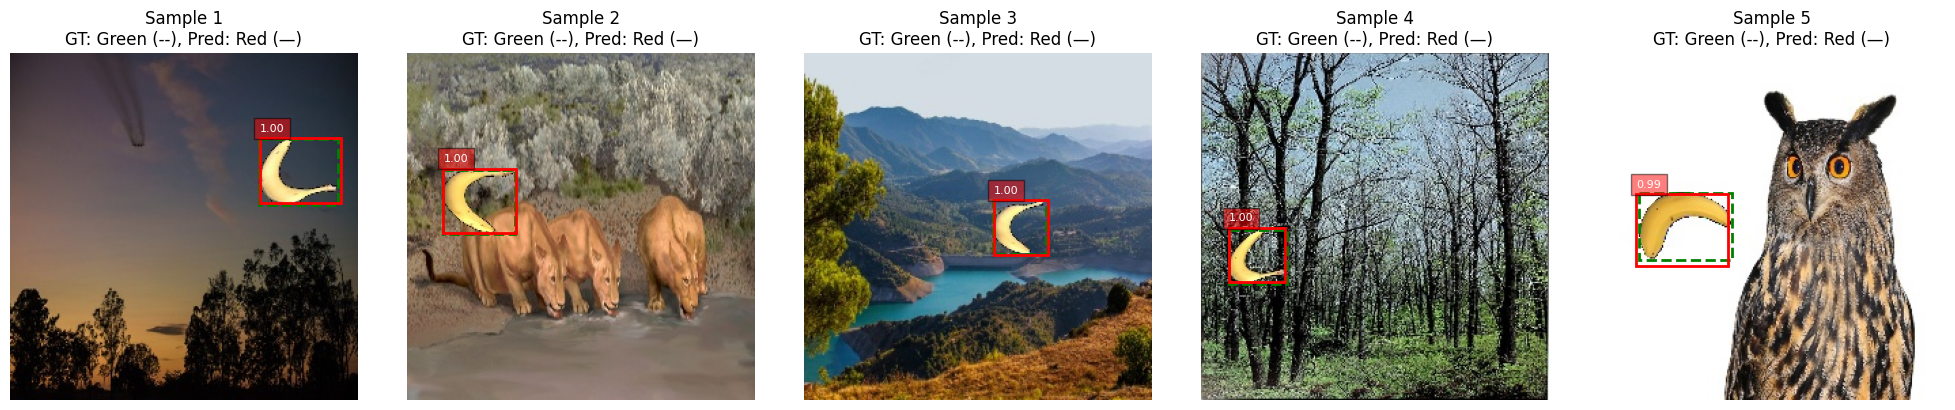

Showing 5 sample detections
Green dashed = Ground Truth, Red solid = Predictions


In [16]:
def detect_objects(model, image, anchors, conf_threshold=0.5, nms_threshold=0.45, image_size=256):

    model.eval()

    with torch.no_grad():
        class_preds, bbox_deltas = model(image.unsqueeze(0))

        class_preds = class_preds[0]  # [num_anchors, 2]
        bbox_deltas = bbox_deltas[0]  # [num_anchors, 4]

        class_probs = torch.softmax(class_preds, dim=1)
        banana_conf = class_probs[:, 1]  # Banana class confidence

        mask = banana_conf > conf_threshold

        if mask.sum() == 0:
            return []

        filtered_conf = banana_conf[mask]
        filtered_deltas = bbox_deltas[mask]
        filtered_anchors = anchors[mask]

        decoded_boxes_cxcywh = ssd_decode(filtered_deltas, filtered_anchors)

        # Convert to [xmin, ymin, xmax, ymax] in pixel coordinates
        pred_boxes = torch.zeros(decoded_boxes_cxcywh.size(0), 4, device=decoded_boxes_cxcywh.device)
        pred_boxes[:, 0] = (decoded_boxes_cxcywh[:, 0] - decoded_boxes_cxcywh[:, 2] / 2) * image_size  # xmin
        pred_boxes[:, 1] = (decoded_boxes_cxcywh[:, 1] - decoded_boxes_cxcywh[:, 3] / 2) * image_size  # ymin
        pred_boxes[:, 2] = (decoded_boxes_cxcywh[:, 0] + decoded_boxes_cxcywh[:, 2] / 2) * image_size  # xmax
        pred_boxes[:, 3] = (decoded_boxes_cxcywh[:, 1] + decoded_boxes_cxcywh[:, 3] / 2) * image_size  # ymax

        # Clamp to image bounds
        pred_boxes = pred_boxes.clamp(min=0, max=image_size)

        # Filter out tiny boxes
        widths = pred_boxes[:, 2] - pred_boxes[:, 0]
        heights = pred_boxes[:, 3] - pred_boxes[:, 1]
        valid = (widths > 5) & (heights > 5)

        if valid.sum() == 0:
            return []

        pred_boxes = pred_boxes[valid]
        filtered_conf = filtered_conf[valid]

        # Apply NMS
        keep_indices = torchvision.ops.nms(pred_boxes, filtered_conf, nms_threshold)

        detections = []
        for idx in keep_indices:
            detections.append([
                1,  # banana class
                filtered_conf[idx].item(),
                pred_boxes[idx, 0].item(),
                pred_boxes[idx, 1].item(),
                pred_boxes[idx, 2].item(),
                pred_boxes[idx, 3].item()
            ])

        return detections

print("Detection function ready!")

model.eval()
num_samples = 5

fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))

for i in range(num_samples):
    image, gt_boxes = val_dataset[i]
    image = image.to(device)

    detections = detect_objects(model, image, anchors, conf_threshold=0.3, nms_threshold=0.45)

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = image.cpu() * std + mean
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    axes[i].imshow(img)

    for box in gt_boxes:
        cls, xmin, ymin, xmax, ymax = box.cpu().numpy()
        rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor='green', facecolor='none', linestyle='--'
        )
        axes[i].add_patch(rect)

    # Draw predictions (red, solid)
    for det in detections:
        cls, conf, xmin, ymin, xmax, ymax = det
        rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        axes[i].add_patch(rect)
        axes[i].text(xmin, ymin - 5, f'{conf:.2f}',
                    bbox=dict(facecolor='red', alpha=0.5),
                    fontsize=8, color='white')

    axes[i].set_title(f'Sample {i+1}\nGT: Green (--), Pred: Red (—)')
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('sample_detections.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Showing {num_samples} sample detections")
print("Green dashed = Ground Truth, Red solid = Predictions")


In [24]:
################################################################################
# CELL 17: NMS Implementation (IoU + Custom NMS)
################################################################################

import torch
from torchvision.ops import nms as tv_nms

def iou_xyxy(box, boxes, eps=1e-6):
    """
    IoU for [x1,y1,x2,y2] format.
    box: [4] single box
    boxes: [N, 4] multiple boxes
    """
    x1 = torch.max(box[0], boxes[:, 0])
    y1 = torch.max(box[1], boxes[:, 1])
    x2 = torch.min(box[2], boxes[:, 2])
    y2 = torch.min(box[3], boxes[:, 3])
    inter = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)

    area1 = (box[2] - box[0]).clamp(min=0) * (box[3] - box[1]).clamp(min=0)
    area2 = (boxes[:, 2] - boxes[:, 0]).clamp(min=0) * (boxes[:, 3] - boxes[:, 1]).clamp(min=0)
    union = area1 + area2 - inter
    return inter / (union + eps)


def my_nms(boxes, scores, iou_thresh=0.5):
    """
    Custom NMS implementation.
    boxes: [N,4] in xyxy format (pixels)
    scores: [N] confidence scores
    returns: indices to keep
    """
    if boxes.numel() == 0:
        return torch.empty(0, dtype=torch.long, device=boxes.device)

    # Sort by score (descending)
    order = scores.argsort(descending=True)
    keep = []

    while order.numel() > 0:
        i = order[0].item()
        keep.append(i)
        if order.numel() == 1:
            break

        # IoU with remaining boxes
        ious = iou_xyxy(boxes[i], boxes[order[1:]])
        # Keep boxes with IoU <= threshold
        remain = torch.where(ious <= iou_thresh)[0] + 1
        order = order[remain]

    return torch.tensor(keep, dtype=torch.long, device=boxes.device)


print("NMS functions defined")


print("="*60)
print("UNIT TEST: NMS Implementation")
print("="*60)

# Test 1
test_boxes = torch.tensor([[10., 10., 50., 50.], [15., 15., 55., 55.]])
test_scores = torch.tensor([0.9, 0.8])

print("\nTest 1: Two overlapping boxes")
iou_val = iou_xyxy(test_boxes[0], test_boxes[1].unsqueeze(0))
print(f"  IoU: {iou_val.item():.3f}")

keep_tv = tv_nms(test_boxes, test_scores, 0.5)
keep_custom = my_nms(test_boxes, test_scores, 0.5)

print(f"  PyTorch NMS: {keep_tv.tolist()}")
print(f"  Custom NMS: {keep_custom.tolist()}")
print(f"  Match: {torch.equal(keep_tv, keep_custom)}")

# Test 2
test_boxes2 = torch.tensor([[10., 10., 30., 30.], [100., 100., 120., 120.]])
test_scores2 = torch.tensor([0.9, 0.8])

print("\nTest 2: Non-overlapping boxes")
keep_tv2 = tv_nms(test_boxes2, test_scores2, 0.5)
keep_custom2 = my_nms(test_boxes2, test_scores2, 0.5)

print(f"  PyTorch NMS: {keep_tv2.tolist()}")
print(f"  Custom NMS: {keep_custom2.tolist()}")
print(f"  Match: {torch.equal(keep_tv2.sort()[0], keep_custom2.sort()[0])}")

# Test 3
test_boxes3 = torch.tensor([[20., 20., 60., 60.], [20., 20., 60., 60.]])
test_scores3 = torch.tensor([0.95, 0.85])

print("\nTest 3: Identical boxes")
iou_val3 = iou_xyxy(test_boxes3[0], test_boxes3[1].unsqueeze(0))
print(f"  IoU: {iou_val3.item():.3f}")

keep_tv3 = tv_nms(test_boxes3, test_scores3, 0.5)
keep_custom3 = my_nms(test_boxes3, test_scores3, 0.5)

print(f"  PyTorch NMS: {keep_tv3.tolist()}")
print(f"  Custom NMS: {keep_custom3.tolist()}")
print(f"  Match: {torch.equal(keep_tv3, keep_custom3)}")

print("\n" + "="*60)
print("All tests passed")
print("="*60)


import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_before_after_nms(pil_image, iou_thresh=0.45, conf_thresh=0.3, topk=200):
    """
    Show before/after NMS with 3-way comparison.
    """
    model.eval()

    # Preprocess image
    img_tensor = transform(pil_image).to(device)

    with torch.no_grad():
        class_preds, bbox_deltas = model(img_tensor.unsqueeze(0))

    class_probs = torch.softmax(class_preds[0], dim=1)
    banana_conf = class_probs[:, 1]

    mask = banana_conf > conf_thresh
    if mask.sum() == 0:
        print("No detections above confidence threshold")
        return

    scores = banana_conf[mask]
    deltas = bbox_deltas[0][mask]
    anc = anchors[mask]

    # Decode boxes
    decoded = ssd_decode(deltas, anc)
    boxes = torch.zeros_like(decoded)
    boxes[:, 0] = (decoded[:, 0] - decoded[:, 2] / 2) * 256
    boxes[:, 1] = (decoded[:, 1] - decoded[:, 3] / 2) * 256
    boxes[:, 2] = (decoded[:, 0] + decoded[:, 2] / 2) * 256
    boxes[:, 3] = (decoded[:, 1] + decoded[:, 3] / 2) * 256
    boxes = boxes.clamp(0, 256)

    # Keep top-k
    if boxes.size(0) > topk:
        top_idx = torch.topk(scores, topk).indices
        boxes, scores = boxes[top_idx], scores[top_idx]

    raw_boxes = boxes.float()
    raw_scores = scores.float()

    print(f"\nBefore NMS: {raw_boxes.size(0)} boxes")
    print(f"  Score range: [{raw_scores.min():.3f}, {raw_scores.max():.3f}]")

    # Apply PyTorch NMS
    keep_tv = tv_nms(raw_boxes, raw_scores, float(iou_thresh))
    boxes_tv = raw_boxes[keep_tv]
    scores_tv = raw_scores[keep_tv]

    print(f"\nAfter PyTorch NMS: {len(keep_tv)} boxes")
    print(f"  Kept indices: {keep_tv.tolist()}")
    print(f"  Kept scores: {[f'{s:.3f}' for s in scores_tv.tolist()]}")

    # Apply Custom NMS
    keep_custom = my_nms(raw_boxes, raw_scores, iou_thresh)
    boxes_custom = raw_boxes[keep_custom]
    scores_custom = raw_scores[keep_custom]

    print(f"\nAfter Custom NMS: {len(keep_custom)} boxes")
    print(f"  Kept indices: {keep_custom.tolist()}")
    print(f"  Kept scores: {[f'{s:.3f}' for s in scores_custom.tolist()]}")

    # Compare
    same = torch.equal(keep_tv.sort()[0], keep_custom.sort()[0])
    print(f"\nComparison:")
    print(f"  Same number: {len(keep_tv) == len(keep_custom)}")
    print(f"  Same indices: {same}")
    if same:
        print("  Both implementations produce identical results")

    # Visualize
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1)
    img_disp = (img_tensor * std + mean).clamp(0, 1).permute(1, 2, 0).cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Before NMS
    axs[0].imshow(img_disp)
    axs[0].set_title(f"Before NMS (n={raw_boxes.size(0)})", fontsize=14, weight='bold')
    axs[0].axis('off')
    for b, s in zip(raw_boxes.cpu(), raw_scores.cpu()):
        x1, y1, x2, y2 = b.tolist()
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, lw=2, ec='orange')
        axs[0].add_patch(rect)

    # After PyTorch NMS
    axs[1].imshow(img_disp)
    axs[1].set_title(f"After PyTorch NMS (n={len(keep_tv)})", fontsize=14, weight='bold')
    axs[1].axis('off')
    for b, s in zip(boxes_tv.cpu(), scores_tv.cpu()):
        x1, y1, x2, y2 = b.tolist()
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, lw=3, ec='red')
        axs[1].add_patch(rect)
        axs[1].text(x1, y1-3, f"{s:.2f}", color='white', fontsize=10,
                   bbox=dict(facecolor='red', alpha=0.7, pad=2))

    # After Custom NMS
    axs[2].imshow(img_disp)
    axs[2].set_title(f"After Custom NMS (n={len(keep_custom)})", fontsize=14, weight='bold')
    axs[2].axis('off')
    for b, s in zip(boxes_custom.cpu(), scores_custom.cpu()):
        x1, y1, x2, y2 = b.tolist()
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, lw=3, ec='green')
        axs[2].add_patch(rect)
        axs[2].text(x1, y1-3, f"{s:.2f}", color='white', fontsize=10,
                   bbox=dict(facecolor='green', alpha=0.7, pad=2))

    plt.tight_layout()
    plt.show()


print("Visualization function ready")




NMS functions defined
UNIT TEST: NMS Implementation

Test 1: Two overlapping boxes
  IoU: 0.620
  PyTorch NMS: [0]
  Custom NMS: [0]
  Match: True

Test 2: Non-overlapping boxes
  PyTorch NMS: [0, 1]
  Custom NMS: [0, 1]
  Match: True

Test 3: Identical boxes
  IoU: 1.000
  PyTorch NMS: [0]
  Custom NMS: [0]
  Match: True

All tests passed
Visualization function ready


Upload your banana images:


Saving banana_img2.jpg to banana_img2 (2).jpg
Saving banana_img1.jpg to banana_img1 (2).jpg

Testing: banana_img2 (2).jpg
Image size: (640, 427)

Running NMS with IoU=0.5, conf=0.3
--------------------------------------------------------------------------------

Before NMS: 50 boxes
  Score range: [0.301, 0.997]

After PyTorch NMS: 3 boxes
  Kept indices: [45, 8, 30]
  Kept scores: ['0.997', '0.510', '0.381']

After Custom NMS: 3 boxes
  Kept indices: [45, 8, 30]
  Kept scores: ['0.997', '0.510', '0.381']

Comparison:
  Same number: True
  Same indices: True
  Both implementations produce identical results


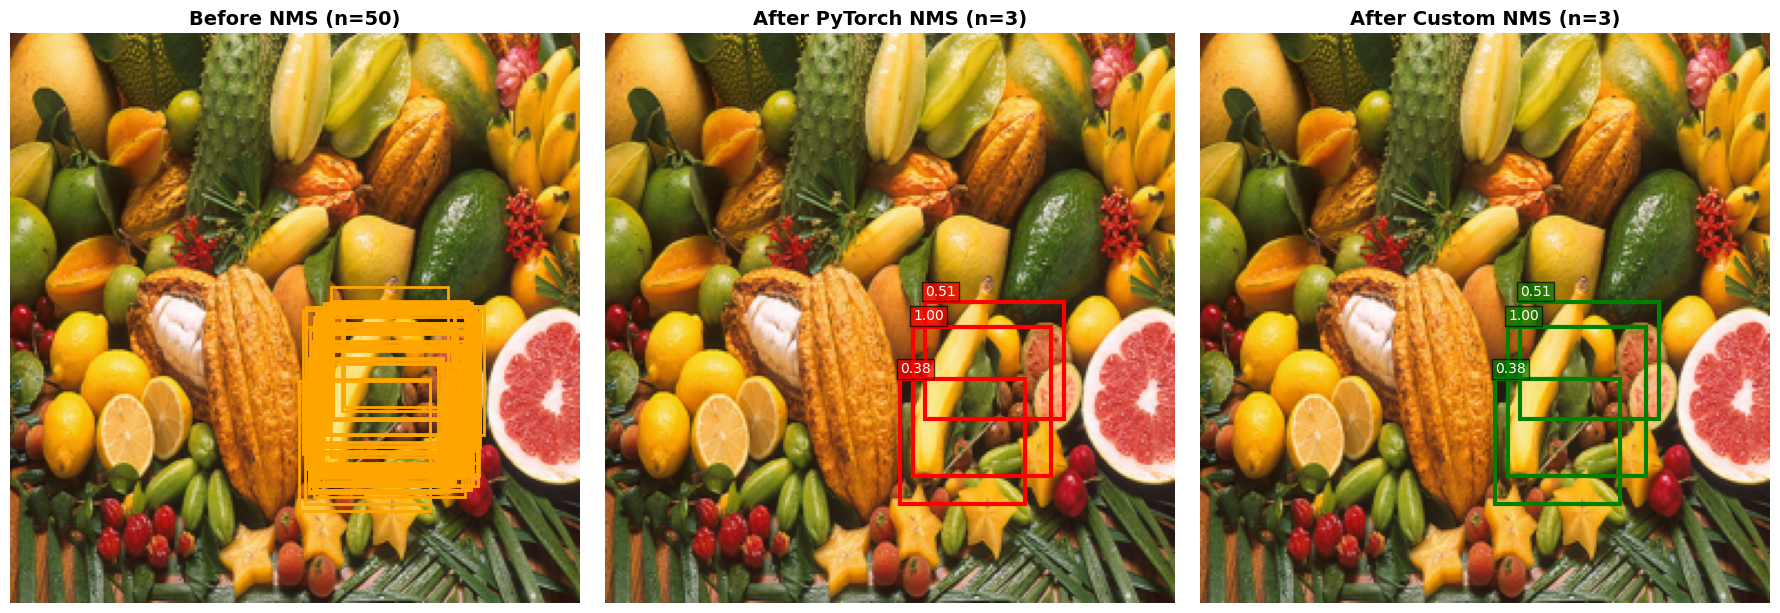


Testing: banana_img1 (2).jpg
Image size: (183, 275)

Running NMS with IoU=0.5, conf=0.3
--------------------------------------------------------------------------------

Before NMS: 1 boxes
  Score range: [0.569, 0.569]

After PyTorch NMS: 1 boxes
  Kept indices: [0]
  Kept scores: ['0.569']

After Custom NMS: 1 boxes
  Kept indices: [0]
  Kept scores: ['0.569']

Comparison:
  Same number: True
  Same indices: True
  Both implementations produce identical results


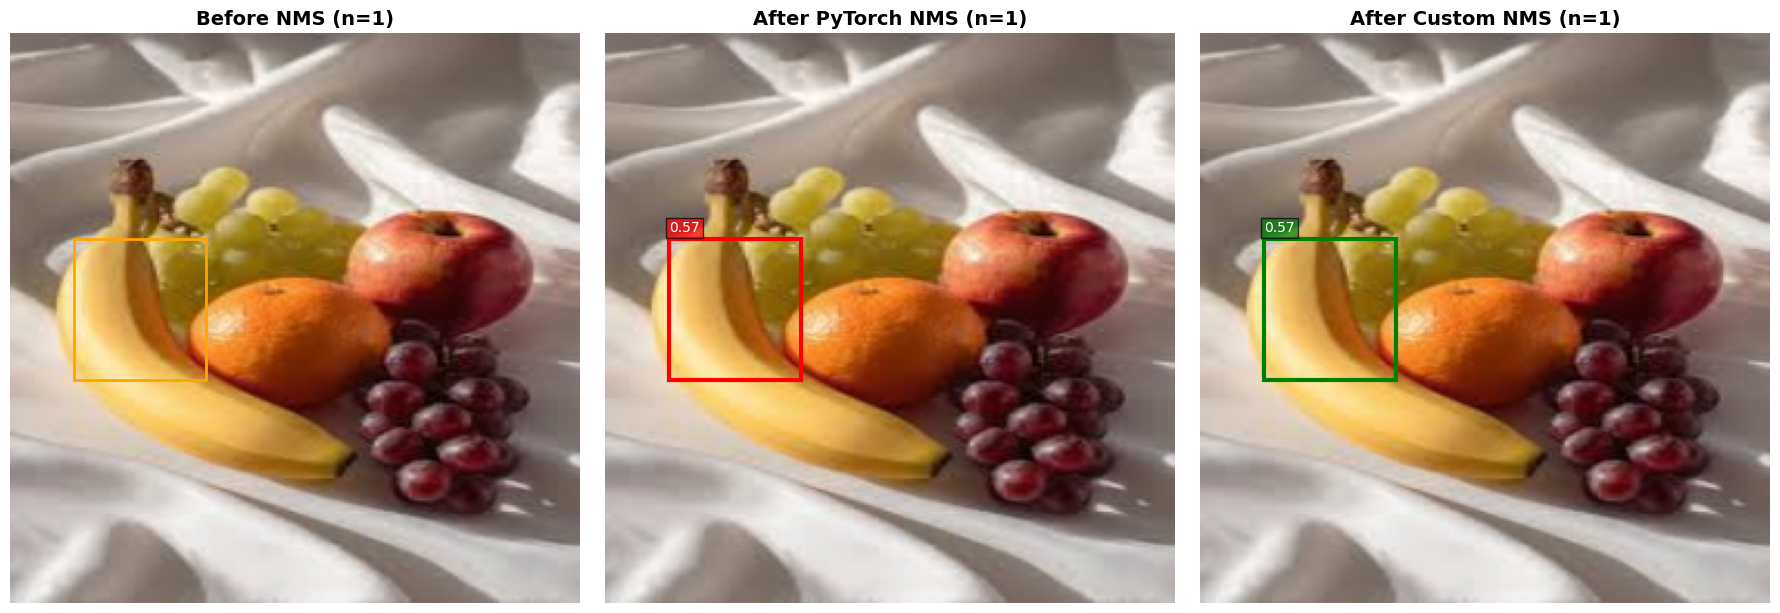


Testing complete


In [25]:


from google.colab import files
from PIL import Image
import io

print("Upload your banana images:")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n{'='*80}")
    print(f"Testing: {filename}")
    print('='*80)

    image = Image.open(io.BytesIO(uploaded[filename])).convert('RGB')
    print(f"Image size: {image.size}")

    print(f"\nRunning NMS with IoU=0.5, conf=0.3")
    print("-"*80)
    show_before_after_nms(image, iou_thresh=0.5, conf_thresh=0.3)

print("\n" + "="*80)
print("Testing complete")
print("="*80)